In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import time

kafka_topic_name = "songTopic"
kafka_bootstrap_servers = 'localhost:9092'

spark = SparkSession \
        .builder \
        .appName("Spotify Streaming Reccomendation System") \
        .master("local[*]") \
        .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

# Construct a streaming DataFrame that reads from test-topic
# songs_df is the raw data stream, in "kafka" format.
# default for startingOffsets is "latest", but "earliest" allows rewind for missed alerts
songs_df = spark \
        .readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", kafka_bootstrap_servers) \
        .option("subscribe", kafka_topic_name) \
        .option("startingOffsets", "latest") \
        .load()
print("Printing Schema of songs_df: ")
songs_df.printSchema()

'''
Schema of songs_df
|-- key: binary (nullable=true)
|-- value: binary (nullable=true)
|-- topic: string (nullable=true)
|-- partition: integer (nullable=true)
|-- offset: lang (nullable=true)
|-- timestamp: timestamp (nullable=true)
|-- timestampType: integer (nullable=true)
'''

songs_df1 = songs_df.selectExpr("CAST(value AS STRING)", "timestamp") #take only 'value' col and since by default the value is in byte aray format.
#df1 = df.selectExpr("CAST(value AS STRING)", "CAST(timestamp AS TIMESTAMP)").as[(String, Timestamp)]

# Convert Stream according to schema along with TimeStamp
songs_schema_string = "order_id INT,track_id STRING, track_name STRING,track_pop INT, track_duration DOUBLE, " \
                           + "album STRING, artist_names STRING, added_at STRING, " \
                           + "danceability DOUBLE, " \
                           + "energy DOUBLE, key INT, loudness DOUBLE, " \
                           + "speechiness DOUBLE, " \
                           + "acousticness DOUBLE, instrumentalness DOUBLE, liveness DOUBLE, " \
                           + "valence DOUBLE, tempo DOUBLE, time_signature DOUBLE"


songs_df2 = songs_df1.select(from_csv(col("value"), songs_schema_string).alias("song"), "timestamp")

songs_df3 = songs_df2.select("song.*", "timestamp")

def simple():    
    songs_df3.createOrReplaceTempView("song_find");
    song_find_text = spark.sql("SELECT name, artists FROM song_find")
    songs_agg_write_stream = song_find_text \
            .writeStream \
            .trigger(processingTime='5 seconds') \
            .outputMode("update") \
            .option("truncate", "false") \
            .format("console") \
            .start()

    songs_agg_write_stream.awaitTermination()

    print("Songs Streaming...")
    
def csv_output():    
    song_find_text = spark.sql("SELECT name, artists FROM song_find")
    songs_agg_write_stream = song_find_text \
            .writeStream \
            .trigger(processingTime='5 seconds') \
            .outputMode("append") \
            .option("truncate", "false") \
            .option("path",'answ') \
            .option("checkpointLocation", "checkpoint_path") \
            .format("csv") \
            .start()

    songs_agg_write_stream.awaitTermination()

    print("Songs Streaming...")

print("Printing Schema of songs_df3: ")
songs_df3.printSchema()
    
#  create an SQL View so that the data streaming can be put into a View and written to memory. We use a processing time of 5 seconds in append mode to get all the data incoming from the producer.
songs_df3.createOrReplaceTempView("song_find");
song_find_text = spark.sql("SELECT * FROM song_find")


print("Printing Schema of song_find_text: ")
song_find_text.printSchema()
# with a processing time of 5 seconds, we can receive data in batches. 
songs_agg_write_stream = song_find_text \
        .writeStream \
        .trigger(processingTime='5 seconds') \
        .outputMode("append") \
        .option("truncate", "false") \
        .format("memory") \
        .queryName("testedTable2") \
        .start()

songs_agg_write_stream.awaitTermination(1)

Printing Schema of songs_df: 
root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

Printing Schema of songs_df3: 
root
 |-- order_id: integer (nullable = true)
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_pop: integer (nullable = true)
 |-- track_duration: double (nullable = true)
 |-- album: string (nullable = true)
 |-- artist_names: string (nullable = true)
 |-- added_at: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nul

False

In [30]:
import pandas as pd
import random
song_data = pd.read_csv('raw_data.csv')
song_data.rename( columns={'Unnamed: 0':'order_id'}, inplace=True )
print(song_data.columns)
song_data = song_data.drop(['track_id', 'artist_pop','added_at','artist_genres',  'time_signature','track_duration','order_id'], axis='columns')
print(song_data.head())
rand_n = random. randint(0,len(song_data)-1)
add_df = song_data.head(rand_n)[-1:]

Index(['order_id', 'track_id', 'track_name', 'artist_names', 'artist_pop',
       'artist_genres', 'album', 'track_pop', 'track_duration', 'added_at',
       'acousticness', 'speechiness', 'key', 'liveness', 'instrumentalness',
       'energy', 'tempo', 'time_signature', 'loudness', 'danceability',
       'valence'],
      dtype='object')
         track_name  artist_names             album  track_pop  acousticness  \
0         As It Was  Harry Styles         As It Was        100        0.3420   
1       Moscow Mule     Bad Bunny  Un Verano Sin Ti         91        0.2940   
2   Me Porto Bonito     Bad Bunny  Un Verano Sin Ti         89        0.0901   
3     Ojitos Lindos     Bad Bunny  Un Verano Sin Ti         89        0.0800   
4  Tití Me Preguntó     Bad Bunny  Un Verano Sin Ti         88        0.0993   

   speechiness  key  liveness  instrumentalness  energy    tempo  loudness  \
0       0.0557    6    0.3110          0.001010   0.731  173.930    -5.338   
1       0.0333    5   

In [31]:
add_df

,track_name,artist_names,album,track_pop,acousticness,speechiness,key,liveness,instrumentalness,energy,tempo,loudness,danceability,valence
16,La Corriente,Bad Bunny,Un Verano Sin Ti,85,0.229,0.195,11,0.219,0.0,0.786,196.12,-3.51,0.663,0.579


In [32]:
df = spark.sql("SELECT * FROM testedTable2")


df = df.sort(df.added_at.desc())

df_stream = df

df = df.drop('order_id',
 'track_id',
 'added_at',
 'time_signature',
 'track_duration',
 'timestamp')
df.show()
df_sp = spark.createDataFrame(add_df)
print('+++++')
df_sp.show()
df = df.union(df_sp)

from pyspark.ml.feature import VectorAssembler
assembler=VectorAssembler(inputCols=[
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo'], outputCol='features')
assembled_data=assembler.setHandleInvalid("skip").transform(df)

#We use a standard scaler to scale the features column we generated earlier. So that this scaled column can be further used to perform K-Means clustering.
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
df=data_scale.transform(assembled_data)

#Now, this is a step that we can skip if we want. But when we have very large data incoming it is always better that we perform K-Means so that we can cluster data 
#and then we can use the recommendation on this clustered dataset based on what cluster our favorite song falls.
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')


KMeans_algo=KMeans(featuresCol='standardized', k=3)
    
KMeans_fit=KMeans_algo.fit(df)
    
output_df =KMeans_fit.transform(df)

+--------------------+---------+--------------------+---------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+
|          track_name|track_pop|               album|   artist_names|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|
+--------------------+---------+--------------------+---------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+
|           Un Ratito|       87|    Un Verano Sin Ti|      Bad Bunny|       0.787| 0.546|  0|  -7.094|     0.0532|       0.305|         4.55E-5|   0.122|  0.222|  93.05|
|    Yo No Soy Celoso|       86|    Un Verano Sin Ti|      Bad Bunny|       0.872| 0.588|  0|  -6.276|     0.0492|       0.275|             0.0|    0.17|   0.93|142.004|
|            PROVENZA|       90|            PROVENZA|        KAROL G|        0.87| 0.516|  1|  -8.006|     0.0541|       0.656|         0.00823|    0.

In [34]:
#Recommendation system code  
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

class SpotifyRecommender():
    def __init__(self, rec_data):
        self.rec_data_ = rec_data
    
    def spotify_recommendations(self, song_name, amount=1):
        distances = []
        song = self.rec_data_[(self.rec_data_.track_name.str.lower() == song_name.lower())].head(1).values[0]
        # get details of our fav song from name we pass as x earlier.
        res_data = self.rec_data_[self.rec_data_.track_name.str.lower() != song_name.lower()]
        #dropping the data with our fav song so that it doesnt affect our recommendation.
        for r_song in tqdm(res_data.values):
            # tqdm is just used for showing the bar of iteration through our streamed songs.
            dist = 0
            for col in np.arange(len(res_data.columns)):
                # (len(res_data.columns) gets us the number of columns -> 13 in our case.
                #indeces of non-numerical columns neednt be considered.
                if not col in [0,1,13]:
                    #calculating the manhettan distances for each numerical feature
                    # song -> from our fav dataset.
                    # r_song -> from streaming data.
                    dist = dist + np.absolute(float(song[col]) - float(r_song[col]))
            distances.append(dist)
            # distances are calculated and appended and added to a new column called distances in our dataset.
        res_data['distance'] = distances
        #sorting our data to be ascending by 'distance' feature
        res_data = res_data.sort_values('distance')
        # resulting dataset have the song similar to our fav song's numerical values and thus recommended.
        columns = ['track_name', 'artist_names', 'acousticness', 'liveness', 'instrumentalness', 'energy', 'danceability', 'valence']
        return res_data[columns][:amount]
    
    
datad = output_df.select('track_name',
 'artist_names',
 'danceability',
 'energy',
 'key',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'prediction')



datf = datad.toPandas()
datf.drop(datf[datf['artist_names'] == '0'].index, inplace = True)
datf.drop_duplicates(inplace=True)
datf.drop(datf[datf['danceability'] == 0.0000].index, inplace = True)
datf.drop(datf[datf['liveness'] == 0.000].index, inplace = True)
datf.drop(datf[datf['instrumentalness'] == 0.000000].index, inplace = True)
datf.drop(datf[datf['energy'] == 0.0000].index, inplace = True)
datf.drop(datf[datf['danceability'] == 0.000].index, inplace = True)
datf.drop(datf[datf['valence'] == 0.000].index, inplace = True)

y = datf
value_pred = datf.iloc[-1:]['prediction']
#datf = datf[datf['prediction'] == list(value_pred)[0]]

recommender = SpotifyRecommender(datf)
x = add_df['track_name'].tolist()[0]

rec_song = recommender.spotify_recommendations(x, 10)

v = add_df[['track_name', 'artist_names',  'acousticness', 'liveness', 'instrumentalness', 'energy', 
       'danceability', 'valence']]

rec_song = pd.concat([rec_song, v])
rec_song.to_csv('rec_song.csv')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 23122.96it/s]


In [35]:
df_rec = spark.createDataFrame(rec_song)
df_rec.show()

+--------------------+--------------+-------------------+-------------------+----------------+------------------+------------------+-------+
|          track_name|  artist_names|       acousticness|           liveness|instrumentalness|            energy|      danceability|valence|
+--------------------+--------------+-------------------+-------------------+----------------+------------------+------------------+-------+
|          Heat Waves| Glass Animals|               0.44|             0.0921|          6.7E-6|             0.525|             0.761|  0.531|
|Me Fui de Vacaciones|     Bad Bunny|              0.229|             0.0942|          8.3E-4|             0.645|             0.714|  0.434|
|        X ÚLTIMA VEZ|  Daddy Yankee|             0.0789|              0.108|         1.67E-4|             0.855|             0.812|  0.573|
|Una Noche en Mede...|       Cris Mj|             0.0924|             0.0534|          4.6E-5|             0.548|              0.87|  0.832|
|        Dese

#### Verification for feature selection

In [37]:
!pip install pyspark-dist-explore

You should consider upgrading via the 'c:\users\shubh\anaconda3\python.exe -m pip install --upgrade pip' command.


In [38]:
pca_col = [
 'danceability',
 'energy',
 'key',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import seaborn as sns
x = df_stream.na.drop("any")
x1 = x.toPandas()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'MAMIII'),
  Text(1, 0, 'abcdefu'),
  Text(2, 0, 'MIDDLE OF THE NIGHT'),
  Text(3, 0, 'Una Noche en Medellín'),
  Text(4, 0, 'Woman'),
  Text(5, 0, 'Where Are You Now'),
  Text(6, 0, 'PROVENZA'),
  Text(7, 0, 'Shivers'),
  Text(8, 0, 'Heat Waves'),
  Text(9, 0, 'good 4 u')])

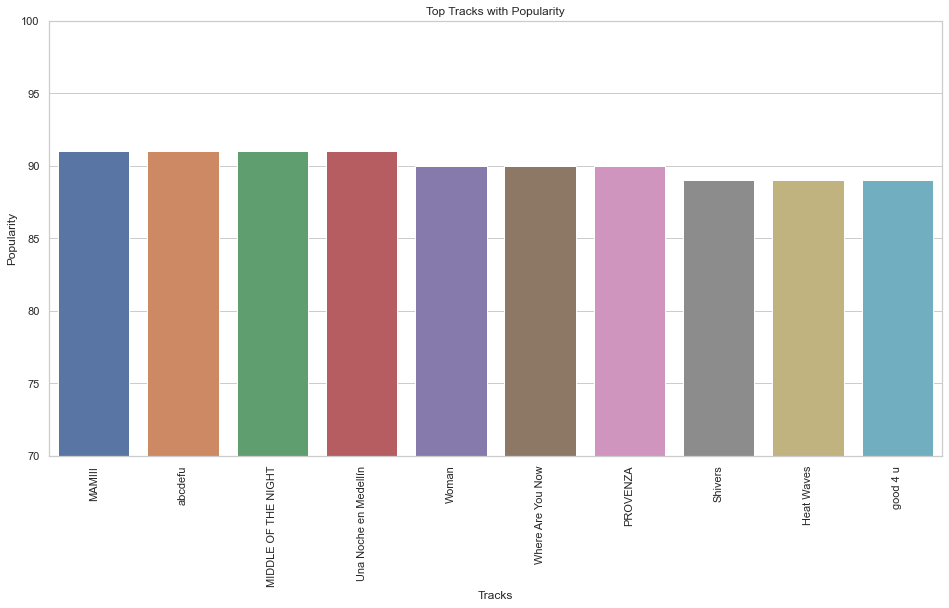

In [41]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
y = x1.groupby("track_name")["track_pop"].mean().sort_values(ascending=False).head(10)
ax = sns.barplot(y.index, y)
ax.set_title('Top Tracks with Popularity')
ax.set_ylabel('Popularity')
ax.set_xlabel('Tracks')
ax.set_ylim(70,100)
plt.xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'GAYLE'),
  Text(1, 0, 'Elley Duhé'),
  Text(2, 0, 'Becky G'),
  Text(3, 0, 'Cris Mj'),
  Text(4, 0, 'Lost Frequencies'),
  Text(5, 0, 'KAROL G'),
  Text(6, 0, 'Doja Cat'),
  Text(7, 0, 'Olivia Rodrigo'),
  Text(8, 0, 'Daddy Yankee'),
  Text(9, 0, 'Ed Sheeran')])

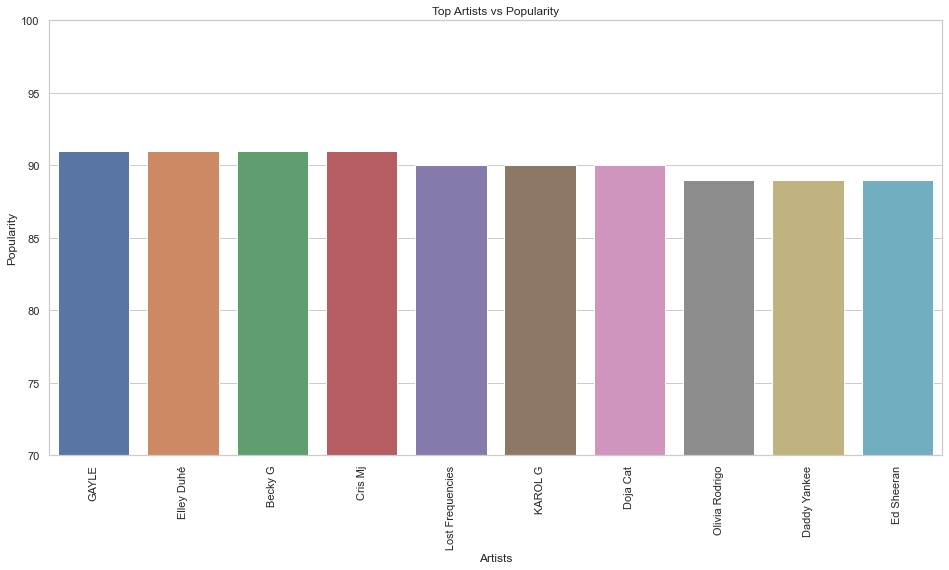

In [42]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
y2 = x1.groupby("artist_names")["track_pop"].mean().sort_values(ascending=False).head(10)
ax = sns.barplot(y2.index,y2)
ax.set_title('Top Artists vs Popularity')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artists')
ax.set_ylim(70,100)
plt.xticks(rotation = 90)